# Constrained Likelihood

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#|default_exp likelihood

In [3]:
#|export
import jax
import jax.numpy as jnp
from jax import (jit, vmap)
import genjax
from genjax import gen, choice_map, vector_choice_map
import matplotlib.pyplot as plt
import numpy as np
import bayes3d
from xsight.utils import *

console = genjax.pretty(show_locals=False)
key     = jax.random.PRNGKey(0)

In [4]:
#|export
import genjax._src.generative_functions.distributions.tensorflow_probability as gentfp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

uniform = genjax.tfp_uniform

truncnormal = gentfp.TFPDistribution(
    lambda mu, sig, low, high: tfd.TruncatedNormal(mu, sig, low, high));

normal = gentfp.TFPDistribution(
    lambda mu, sig: tfd.Normal(mu, sig));

diagnormal = gentfp.TFPDistribution(
    lambda mus, sigs: tfd.MultivariateNormalDiag(mus, sigs));


mixture_of_diagnormals = gentfp.TFPDistribution(
    lambda ws, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.MultivariateNormalDiag(mus, sig * jnp.ones_like(mus))))

mixture_of_normals = gentfp.TFPDistribution(
    lambda ws, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.Normal(mus, sig * jnp.ones_like(mus))))


mixture_of_truncnormals = gentfp.TFPDistribution(
    lambda ws, mus, sigs, lows, highs: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.TruncatedNormal(mus, sigs, lows, highs)))

In [5]:
#|export
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf    = jax.scipy.stats.norm.logpdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
truncnorm_pdf    = jax.scipy.stats.truncnorm.pdf


In [6]:
# This function is adapted from `bayes3d.likelihood.gausssian_mixture_vectorize`
# which computes the pixel-wise logprobs in the 3dp3 likelihood.
def threeDP3_logpdf(x, ys, variance, outlier, vol):
    m     = len(ys)
    diffs = x - ys
    logps = jax.scipy.special.logsumexp( 
        jax.scipy.stats.norm.logpdf(
            diffs,
            loc   = 0.0,
            scale = jnp.sqrt(variance)
        ).sum(-1) - jnp.log(m)
    )
    return jnp.logaddexp(jnp.log(1.0 - outlier) + logps, jnp.log(outlier) - jnp.log(vol))

## 1D Mixture Components

In [7]:
#|export

# TODO: There should be a version that simply 
# returns the projections onto the ray and 
# the distances to the ray.
def get_1d_mixture_components(x, ys, sig):
    """Returns 1d mixture components and thier unnormalized weights."""
    # 1D-Mixture components and value to evaluate.
    # These are given by the distances ALONG ray through `x`
    d  = jnp.linalg.norm(x, axis=-1)
    ds = ys @ x / d
    
    # 1D-Mixture weights.
    # First compute the distances TO ray through `x`
    # and then transforming them appropriately.
    ws_ = jnp.linalg.norm(ds[...,None] * x/d - ys, axis=-1)
    ws  = normal_logpdf(ws_, loc=0.0, scale=sig) + normal_logpdf(0.0, loc=0.0, scale=sig)

    return d, ds, ws

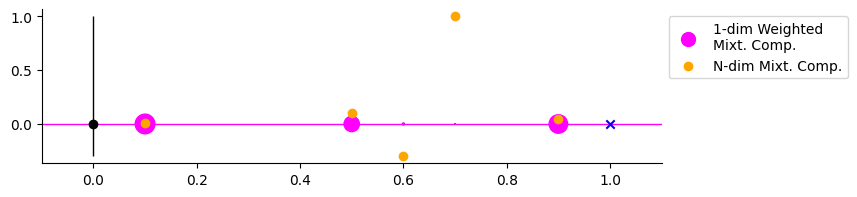

In [8]:
sig  = .1
zmax = 1.

xs = zmax*jnp.linspace(0.0,1.0,1000)[:,None]*jnp.array([0.0, 0.0, 1.0])
x  = xs[-1]
ys = zmax*jnp.array([ 
    [.01, 0., .1],
    [0.1, 0, .5],
    [-.3, 0, .6],
    [1, 0, .7],
    [.05, 0, .9],
])

d, ds, ws = get_1d_mixture_components(x, ys, sig)
ws = ws - logsumexp(ws, axis=-1)

# ------------------------------
fig, ax = plt.subplots(1,1, figsize=(8,2), sharex=True)
ax.set_xlim(-0.1*zmax,1.1*zmax)
ax.scatter(ds, jnp.zeros(len(ds)),  s=jnp.exp(ws)*500, c="magenta", label="1-dim Weighted\nMixt. Comp.")
ax.scatter(d, x[0],marker="x", c="blue");
ax.hlines(0, -0.1*zmax,1.1*zmax, color="magenta", zorder=-1, linewidth=1.)
ax.scatter(ys[:,2], ys[:,0], c="orange", label="N-dim Mixt. Comp.")
ax.vlines(0, jnp.min(ys[:,0]), jnp.max(ys[:,0]), color="k", zorder=-1, linewidth=1.)
ax.scatter(0,0, c="k")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Reality Checks 

Comparing the constrained 1d mixture with restricted 3d mixture and Nishad's 3dp3 likelihood.

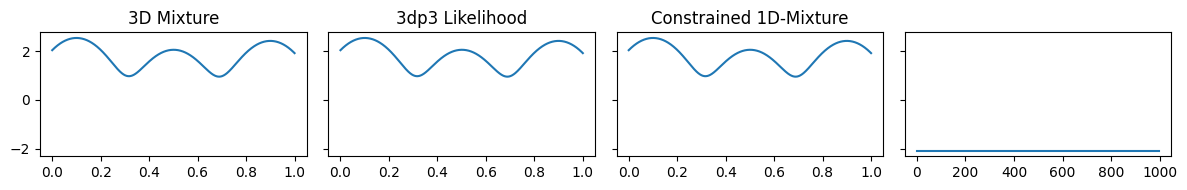

In [9]:
sig = .1

# Baseline of 3D-Mixture
ws0 = jnp.zeros(len(ys)) - jnp.log(len(ys))
ps0 = vmap(lambda x: 
            mixture_of_diagnormals.logpdf(x, ws0, ys, sig)
      )(xs)

# 3dp3 Likelihood
ps1 = vmap(lambda x: threeDP3_logpdf(x, ys, sig**2, 0.0, 1.0))(xs)


# Constrained 1D-Mixture
_, ds, ws = get_1d_mixture_components(xs[-1], ys, sig)
offset = logsumexp(ws) - jnp.log(len(ws))
ps2 = vmap(lambda x: 
            mixture_of_normals.logpdf(x, ws, ds, sig)
      )(jnp.linalg.norm(xs, axis=-1))
ps2 += offset


# =======================================
fig, axs = plt.subplots(1,4, figsize=(12,2), sharey=True)
axs[0].set_title("3D Mixture")
axs[0].plot(jnp.linalg.norm(xs, axis=-1), ps0)
axs[1].set_title("3dp3 Likelihood")
axs[1].plot(jnp.linalg.norm(xs, axis=-1), ps1)
axs[2].set_title("Constrained 1D-Mixture")
axs[2].plot(jnp.linalg.norm(xs, axis=-1), ps2)
axs[3].plot(ps0 - ps2- offset);
fig.tight_layout()

In [10]:
sig = 0.2
x = jnp.array(np.random.randn(3))
y = jnp.array(np.random.randn(3))

d = jnp.linalg.norm(x)
y_ = y@x/d
w_ = jnp.linalg.norm(y_*x/d - y)


(
    diagnormal.logpdf(x, y, sig*jnp.ones_like(y)),
    normal.logpdf(d, y_, sig) + normal.logpdf(w_, 0, sig) + normal.logpdf(0.0, 0.0, sig),
)

(Array(-45.627403, dtype=float32), Array(-45.627407, dtype=float32))

In [11]:
sig = 0.2

x  = jnp.array(np.random.randn(3))
ys = jnp.array(np.random.randn(20,3))

d   = jnp.linalg.norm(x)
ys_ = jnp.dot(ys,x) / d
ws_ = jnp.linalg.norm(ys_[:,None]*x[None]/d - ys, axis=-1)
ws_ = normal_logpdf(ws_, 0.0, sig) + normal_logpdf(0.0, 0.0, sig)


(
    mixture_of_diagnormals.logpdf(x, jnp.zeros(len(ys)), ys, sig),

    logsumexp(jnp.array([
        diagnormal.logpdf(x, y, sig*jnp.ones_like(y)) for y in ys
    ])) - jnp.log(len(ys)),

    logsumexp(jnp.array([
        normal_logpdf(d, y_, sig) + w_ for y_,w_ in zip(ys_, ws_)
    ])) - jnp.log(len(ys)),

    mixture_of_normals.logpdf(d, ws_, ys_, sig) + logsumexp(ws_) - jnp.log(len(ys))
)

(
    Array(-2.3233175, dtype=float32),
    Array(-2.3233175, dtype=float32),
    Array(-2.323317, dtype=float32),
    Array(-2.3233166, dtype=float32)
)

## Constrained Likelihood Model

In [12]:
#|export
# Some helper to keep code concise
min = jnp.minimum
max = jnp.maximum


def dslice(X, i, j, w):     
    m = 2*w + 1
    return  jax.lax.dynamic_slice(X, (i, j, 0), (m, m, 3))   


def pad(X, w, val=-100.0):
    return jax.lax.pad(X,  val, ((w,w,0),(w,w,0),(0,0,0)))


def mix_std(ps, mus, stds):
    """Standard Deviation of a mixture of Gaussians."""
    return jnp.sqrt(jnp.sum(ps*stds**2) + jnp.sum(ps*mus**2) - (jnp.sum(ps*mus))**2)

In [13]:
#|export
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_constrained_sensor_model(zmax, w):
    """Returns an (untruncated) constrained sensor model marginalized over outliers."""    

    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w] 
        ys = dslice(Y_, i, j, w).reshape(-1,3)
        
        d, ds, ws = get_1d_mixture_components(y, ys, sig)

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                mixture_of_normals, genjax.tfp_uniform])

        # Adjustment weights to make up for 
        # the difference to the 3dp3 model
        adj = logsumexp(ws) - jnp.log(len(ws))

        # NOTE: To compare to baseline one should set: `zmax_ = zmax``
        # zmax_ = d/y[2]*zmax
        zmax_ = zmax
        
        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (ws, ds, sig), 
                                    (0.0, zmax_))) @ "measurement"

        return z * y/d, adj

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """Constrained sensor model."""
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X, W = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"
        W = W.reshape(Y.shape[:2])
        X = X.reshape(Y.shape)

        return X, W

    return sensor_model

In [14]:
#|export
def get_data_logprobs(tr):
    pixel_addr = lambda i: genjax.select({"X":
        genjax.index_select(i,  genjax.select("measurement"))
    })
    inds = jnp.arange(tr["X", "measurement"].shape[0])
    logps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
    return logps

## Explicit 3DP3 Baseline Model

In [1]:
#|export
from bayes3d.likelihood import threedp3_likelihood
from genjax.generative_functions.distributions import ExactDensity
from xsight.mixtures import HeterogeneousMixture

class OutlierUniform(ExactDensity):
    def sample(self, key, y, zmax):
        u = zmax*jax.random.uniform(key)
        return u*y

    def logpdf(self, x, y, zmax):
        # y_ = y/jnp.linalg.norm(y)
        # u = jnp.dot(x,y_)
        # return genjax.tfp_uniform.logpdf(u, 0.0, zmax)
        return 1/zmax

outlier_uniform = OutlierUniform()


In [16]:
#|export
def make_baseline_sensor_model(zmax, w):
    """Explicit version of the 3dp3 sensor model."""
  
    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w] 
        ys = dslice(Y_, i, j, w).reshape(-1,3)

        m = len(ys)

        inlier_outlier_mix = HeterogeneousMixture([mixture_of_diagnormals, outlier_uniform])

        # zmax_ = d/y[2]*zmax
        zmax_ = zmax

        x = inlier_outlier_mix(jnp.array([1.0-outlier, outlier]), (
                                    (jnp.zeros(m), ys, sig), 
                                    (y, zmax_))) @ "measurement"

        return x, None

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """Constrained sensor model."""
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X,_ = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"
        X = X.reshape(Y.shape)

        return X, None

    return sensor_model

### Baseline reality check

In [35]:
zmax = 50.
w    = 7

baseline_model = make_baseline_sensor_model(zmax, w)

def _eval_baseline(X, Y, sig, outlier):
    obs = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement": X[:,:,:3].reshape(-1,3)
            }) 
    })
    args = (Y[:,:,:3], sig, outlier)
    w, tr = baseline_model.importance(key, obs, args)
    logps = get_data_logprobs(tr).reshape(X.shape[:2])
    return w, logps


eval_baseline = jit(vmap(_eval_baseline, (None, 0, None, None)))

In [36]:
model = make_constrained_sensor_model(zmax, w)

def _eval_constrained(X, Y, sig, outlier):
    obs = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement":  jnp.linalg.norm(X[:,:,:3], axis=-1).reshape(-1)
            }) 
    })
    args = (Y[:,:,:3], sig, outlier)
    _, tr = model.importance(key, obs, args)
    logps = get_data_logprobs(tr).reshape(X.shape[:2])
    return tr.get_score(), logps, tr.get_retval()[1]

eval_constrained = jit(vmap(_eval_constrained, (None, 0, None, None)))

In [37]:
#  Data created in "Likelihood Test Data" notebook.
# suff = "1x50"
suff = "50x100"
Xs = jnp.load(f"./data/test_Xs_{suff}.npy")
Ys = jnp.load(f"./data/test_Ys_{suff}.npy")
ps = jnp.load(f"./data/test_ps_{suff}.npy")

Xs.shape, Ys.shape

((101, 50, 100, 4), (101, 50, 100, 4))

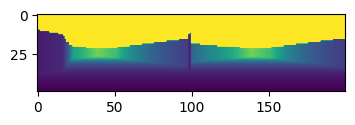

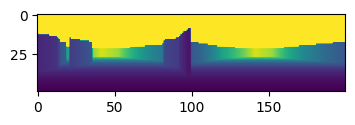

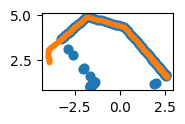

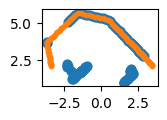

In [38]:
i = 20
j = 15

# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[i,:,:,2],Ys[i,:,:,2]], axis=1), vmax=6);
# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[j,:,:,2],Ys[j,:,:,2]], axis=1), vmax=6);
# ----------
plt.figure(figsize=(4,1))
plt.gca().set_aspect(1)
plt.scatter(Xs[i,Xs.shape[1]//2,:,0],Xs[i,Xs.shape[1]//2,:,2], s=40);
plt.scatter(Ys[i,Xs.shape[1]//2,:,0],Ys[i,Xs.shape[1]//2,:,2], s=10);

# ----------
plt.figure(figsize=(4,1))
plt.gca().set_aspect(1)
plt.scatter(Xs[j,Xs.shape[1]//2,:,0],Xs[j,Xs.shape[1]//2,:,2], s=40);
plt.scatter(Ys[j,Xs.shape[1]//2,:,0],Ys[j,Xs.shape[1]//2,:,2], s=10);


In [39]:
sig     = 0.2
outlier = 0.2


X = Xs[i]
a, a_ = eval_baseline(X, Xs, sig, outlier)
b, b_, w_ = eval_constrained(X, Xs, sig, outlier)
c = jnp.array([threedp3_likelihood(X, Y, sig**2, outlier, zmax, w) for Y in Xs])


2023-08-16 13:55:35.795911: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.27GiB (rounded to 1367561216)requested by op 
2023-08-16 13:55:35.796136: W external/tsl/tsl/framework/bfc_allocator.cc:497] *_______________________________________________________________________________________________**x*
2023-08-16 13:55:35.796297: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2593] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1367560976 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    7.78MiB
              constant allocation:         4B
        maybe_live_out allocation:    3.85MiB
     preallocated temp allocation:    1.27GiB
  preallocated temp fragmentation:       480B (0.00%)
                 total allocation:    1.28GiB
              total fragmentation:     1.4KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 433.44MiB

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_10584/245595676.py:7 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_10584/245595676.py'                         │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/traceback_util.py:166 in           │
│ reraise_with_filtered_traceback                                                                  │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/pjit.py:253 in cache_miss          │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/pjit.py:166 in _python_pjit_helper │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/core.py:2596 in bind               │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/core.py:389 in bind_with_trace     │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/core.py:821 in process_primitive   │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/pjit.py:1209 in _pjit_call_impl    │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/pjit.py:1192 in                    │
│ call_impl_cache_miss                                                                             │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/pjit.py:1148 in                    │
│ _pjit_call_impl_python                                                                           │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/profiler.py:314 in wrapper         │
│                                                                                                  │
│ /opt/conda/envs/bayes3d/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py:1229 in       │
│ __call__                                                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1367560976 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    7.78MiB
              constant allocation:         4B
        maybe_live_out allocation:    3.85MiB
     preallocated temp allocation:    1.27GiB
  preallocated temp fragmentation:       480B (0.00%)
                 total allocation:    1.28GiB
              total fragmentation:     1.4KiB (0.00%)
Peak buffers:
        Buffer 1:
                Size: 433.44MiB
                Operator: op_name="jit(_eval_constrained)/jit(main)/reduce_sum[axes=(2,)]" 
source_file="/home/ubuntu/workspace/genjax/src/genjax/_src/core/interpreters/context.py" source_line=97
                XLA Label: fusion
                Shape: f32[101,5000,225]
                ==========================

  

[<matplotlib.lines.Line2D object at 0x7fb58c07c6d0>]

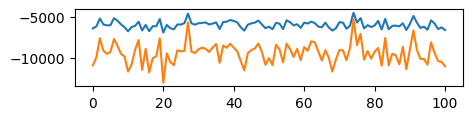

In [40]:
plt.figure(figsize=(5,1))
plt.plot(b - c)
plt.plot(a - c)

[<matplotlib.lines.Line2D object at 0x7fb55ac15450>]

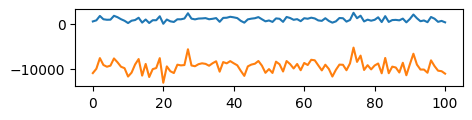

In [41]:
plt.figure(figsize=(5,1))
plt.plot(jnp.sum(b_ + w_, axis=(1,2)) - c)
plt.plot(a - c)

[<matplotlib.lines.Line2D object at 0x7fb55ab8abf0>]

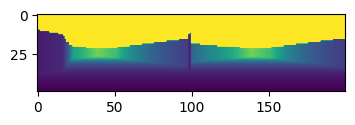

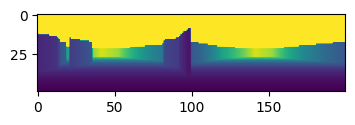

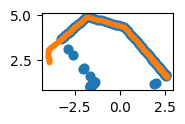

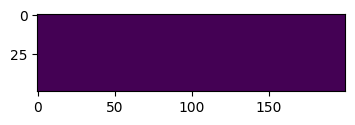

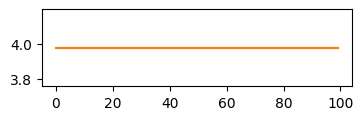

In [42]:

# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[i,:,:,2],Ys[i,:,:,2]], axis=1), vmax=6);
# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[j,:,:,2],Ys[j,:,:,2]], axis=1), vmax=6);
# ----------
plt.figure(figsize=(4,1))
plt.gca().set_aspect(1)
plt.scatter(Xs[i,Xs.shape[1]//2,:,0],Xs[i,Xs.shape[1]//2,:,2], s=40);
plt.scatter(Ys[i,Xs.shape[1]//2,:,0],Ys[i,Xs.shape[1]//2,:,2], s=10);

# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([jnp.exp(w_[i]), jnp.exp(w_[j])], axis=1), vmax=4);
# plt.imshow(jnp.concatenate([w_[i], w_[j]], axis=1));
# ----------
plt.figure(figsize=(4,1))
plt.plot(jnp.exp(w_[i,w_.shape[1]//2]))
plt.plot(jnp.exp(w_[j,w_.shape[1]//2]))
# plt.plot(w_[i,w_.shape[1]//2])
# plt.plot(w_[j,w_.shape[1]//2])


3.9788735 3.9788735
3.9788735 3.9788735


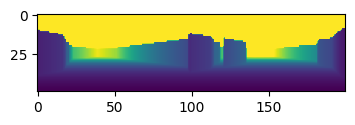

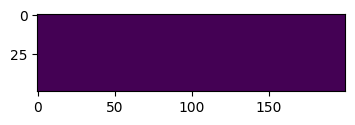

In [43]:
# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[i,:,:,2],Xs[j,:,:,2]], axis=1), vmax=5);
# ----------
plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([jnp.exp(w_[i]), jnp.exp(w_[j])], axis=1));
print(jnp.min(jnp.exp(w_[i])), jnp.max(jnp.exp(w_[i])))
print(jnp.min(jnp.exp(w_[j])), jnp.max(jnp.exp(w_[j])))